# Maximum Likelihood vs CDF-Fit (Spiral B)

In [44]:
import matplotlib.pyplot as plot
import numpy as np
import sympy as sp

from sympy import Symbol, lambdify

from math import exp, log, sqrt
from scipy.optimize import curve_fit, fsolve

import DistA as dist

from StopWatch import StopWatch
from LocUtil import LogGrid1, Grid1, MinMax, UnZip
from LocMath import RandLog

#### Constants

In [2]:
aTrue = 1.7

nMin = 30
nMax = 30_000
nN = 300

givenSeed = None

nPlot = 101

#### Generate List of N's

In [45]:
nL = tuple(round(RandLog(nMin,nMax)) for _ in range(nN))

(153, 1221, 693, 42, 201, 1346, 136, 549, 1402, 1524)

## Estimation Code

In [9]:
termSym = sp.log(dist.pdfSym).diff(dist.aSym).simplify()
termSym

(1 - 2*x)/(a - 2*x*(a - 1))

#### Hand Coded

In [30]:
def MaxEst(samp):
  def f(a, samp):
    assert(type(samp) == np.ndarray)
    terms = (1 - 2*samp) / (a + 2*(1 - a) * samp)
    result = np.sum(terms)
    return result

  result = fsolve(f,1, args=samp)
  return result[0]

In [32]:
timer = StopWatch(running=True)
est = MaxEst(sampNp)
timer.Stop()
est, f'{timer.Delta()}'

(1.696763550584114, '0:00:00.001719')

### MLE Estimator

In [48]:
def MleEst(samp):
  termSym = sp.log(dist.pdfSym).diff(dist.aSym).simplify()
  
  fTemp = (
    'def f(a, x):\n'
    '  terms = {}\n'
    '  result = np.sum(terms)\n'
    '  return result'
  )
  fCode = fTemp.format(termSym)
  # print(fCode)
  
  execScope = {}
  exec(fCode, globals(), execScope)
  f = execScope['f']
  
  timer = StopWatch(running=True)
  ans = fsolve(f,1, args=samp)
  timer.Stop()
  print(timer.Delta())

  return ans

In [37]:
timer = StopWatch(running=True)
est = MaxEst(sampNp)
timer.Stop()
est, f'{timer.Delta()}'

0:00:00.001100


(array([1.69676355]), '0:00:00.023498')

Note that the *fsolve* takes 1.1 ms, while the exec (and a small amount of other setup) takes 22
.3 ms

## Generate Data

In [49]:
mleEst = []

for n in nL:
  samp = np.array(tuple(dist.GenSamp(aTrue) for _ in range(n)))
  
  mEst = MleEst(samp)
  mleEst.append(mEst)

0:00:00.000548
0:00:00.002423
0:00:00.000873
0:00:00.000669
0:00:00.000382
0:00:00.000571
0:00:00.001411
0:00:00.000483
0:00:00.000604
0:00:00.000600
0:00:00.000417
0:00:00.001544
0:00:00.001977
0:00:00.000483
0:00:00.000489
0:00:00.000427
0:00:00.000457
0:00:00.001362
0:00:00.000854
0:00:00.000502
0:00:00.000474
0:00:00.001376
0:00:00.000569
0:00:00.000607
0:00:00.001506
0:00:00.000737
0:00:00.000468
0:00:00.001872
0:00:00.001491
0:00:00.000693
0:00:00.001627
0:00:00.001084
0:00:00.001826
0:00:00.000663
0:00:00.001717
0:00:00.000834
0:00:00.000644
0:00:00.000665
0:00:00.000670
0:00:00.001006
0:00:00.001147
0:00:00.000437
0:00:00.000523
0:00:00.000471
0:00:00.000518
0:00:00.000471
0:00:00.000504
0:00:00.000613
0:00:00.000758
0:00:00.001666
0:00:00.001206
0:00:00.002578
0:00:00.001670
0:00:00.000462
0:00:00.000422
0:00:00.000740
0:00:00.001244
0:00:00.000869
0:00:00.001476
0:00:00.000475
0:00:00.000797
0:00:00.000628
0:00:00.000427
0:00:00.002737
0:00:00.000590
0:00:00.000704
0:00:00.00

In [50]:
mleErr = [aEst - aTrue for aEst in mleEst]

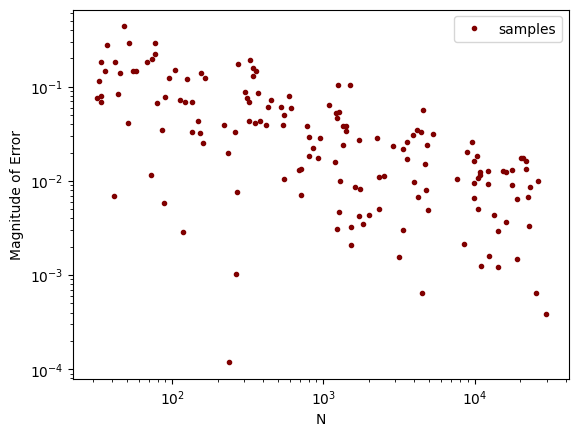

In [51]:
plot.loglog(nL, mleErr, '.', color='maroon', label='samples')

# nGrid = LogGrid1(nMin,nMax, nPlot)
# 
# a0,a1 = mleParam
# fitGrid = [exp(a0) * n**a1 for n in nGrid]
# text = f'{exp(a0):.2f} / n^{-a1:.3f}'
# plot.loglog(nGrid, fitGrid, c='blue', label=text)

plot.xlabel('N')
plot.ylabel('Magnitude of Error')
plot.legend()

## Fit Allowing Power to Adjust

In [9]:
linForm = lambda x,a0,a1: a0 + a1*x

In [10]:
mleParam,_ = curve_fit(linForm, nLog,mleLogErr)
mleParam

array([ 0.01199301, -0.52520715])

In [11]:
cdfParam,_ = curve_fit(linForm, nLog,cdfLogErr)
cdfParam

array([ 0.04429228, -0.5296045 ])

### Maximum Likelihood

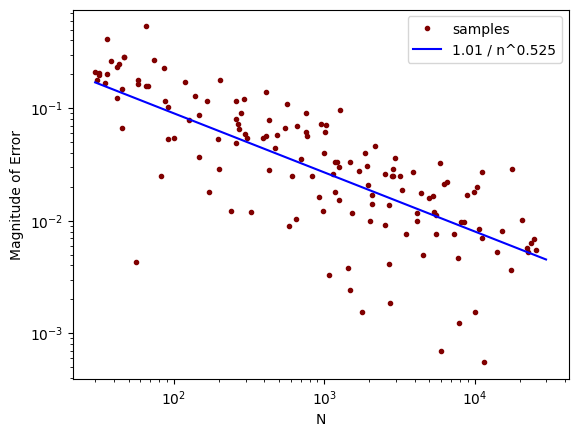

In [12]:
plot.loglog(nL, mleErr, '.', color='maroon', label='samples')

nGrid = LogGrid1(nMin,nMax, nPlot)

a0,a1 = mleParam
fitGrid = [exp(a0) * n**a1 for n in nGrid]
text = f'{exp(a0):.2f} / n^{-a1:.3f}'
plot.loglog(nGrid, fitGrid, c='blue', label=text)

plot.xlabel('N')
plot.ylabel('Magnitude of Error')
plot.legend()

### CDF-Fit

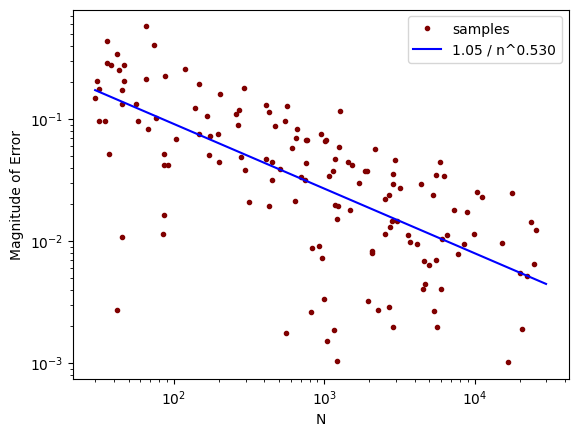

In [13]:
plot.loglog(nL, cdfErr, '.', color='maroon', label='samples')

nGrid = LogGrid1(nMin,nMax, nPlot)

a0,a1 = cdfParam
fitGrid = [exp(a0) * n**a1 for n in nGrid]
text = f'{exp(a0):.2f} / n^{-a1:.3f}'
plot.loglog(nGrid, fitGrid, c='blue', label=text)

plot.xlabel('N')
plot.ylabel('Magnitude of Error')
plot.legend()

## Fit Assuming One Over Square-Root of N

In [31]:
kolmoForm = lambda n, k: k - n/2

In [32]:
mleParam, _ = curve_fit(kolmoForm, nLog, mleLogErr)
mleParam

array([-0.16365491])

In [33]:
cdfParam, _ = curve_fit(kolmoForm, nLog, cdfLogErr)
cdfParam

array([-0.16199716])

### Maximum Likelihood

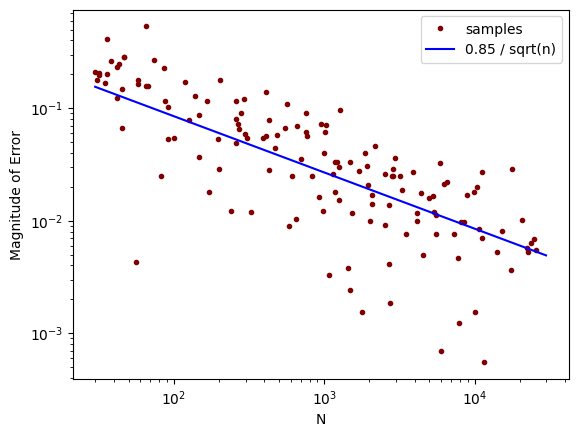

In [34]:
plot.loglog(nL, mleErr, '.', color='maroon', label='samples')

nGrid = LogGrid1(nMin,nMax, nPlot)

k = mleParam[0]
fitGrid = [exp(k) / sqrt(n) for n in nGrid]
text = f'{exp(k):.2f} / sqrt(n)'
plot.loglog(nGrid, fitGrid, c='blue', label=text)

plot.xlabel('N')
plot.ylabel('Magnitude of Error')
plot.legend()

### CDF-Fit

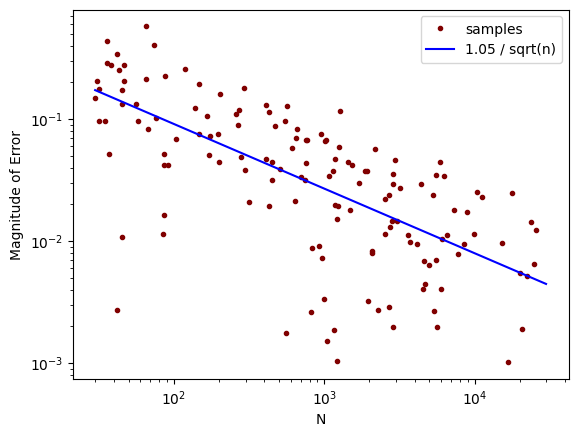

In [35]:
plot.loglog(nL, cdfErr, '.', color='maroon', label='samples')

nGrid = LogGrid1(nMin,nMax, nPlot)

k = cdfParam[0]
fitGrid = [exp(a0) * n**a1 for n in nGrid]
text = f'{exp(a0):.2f} / sqrt(n)'
plot.loglog(nGrid, fitGrid, c='blue', label=text)

plot.xlabel('N')
plot.ylabel('Magnitude of Error')
plot.legend()

## Pair Match

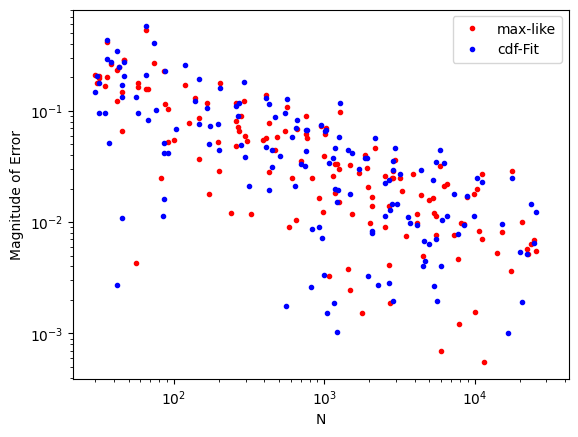

In [39]:
plot.loglog(nL, mleErr, '.', color='red', label='max-like')
plot.loglog(nL, cdfErr, '.', color='blue', label='cdf-Fit')

plot.xlabel('N')
plot.ylabel('Magnitude of Error')
plot.legend()

There appears to be near random superiority